In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("lab2.ipynb")

# EE 120 Lab 2: Applications of LTI Filtering

**Signals and Systems** at UC Berkeley

Acknowledgements:

- **Spring 2019** (v1.0): Dominic Carrano, Sukrit Arora, Babak Ayazifar  
- **Fall 2019** (v2.0): Dominic Carrano  
- **Spring 2020** (v2.1): Dominic Carrano
- **Fall 2020** (v2.1.1): Anmol Parande
- **Spring 2021** (v2.2): Jingjia Chen
- **Spring 2022** (v3.0): Anmol Parande

# Table of Contents
* [Background](#bg)
* [Q1: The 1D Edge Detector](#q1)
    * [Q1.a: Piecewise Constant Signals](#q1a)
    * [Q1.b: The Edge Detector as a DT Differentiator](#q1b)
    * [Q1.c: "Differentiating" Noise](#q1c)
* [Q2: Data Smoothing](#q2)
    * [Q2.a: Noise Reduction](#q2a)
    * [Q2.b: Extracting Trends from Data](#q2b)
* [Q3: The MACD Indicator](#q3)
    * [Q3.a: The Exponential Moving Average](#q3a)
    * [Q3.b: The MACD Line](#q3b)
    * [Q3.b: The Signal Line](#q3c)
* [References](#references)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lab2_helper

%matplotlib inline

<a id='bg'></a>
# Background

Now that you're familiar with the Jupyter notebook environment and the Python language's scientific computing capabilities, you'll get to put your skills to use in exploring some applications of filters (LTI systems).

You'll see some examples of filters in this lab that you've probably also seen in class, such as the moving average or the edge detector. Here, we have a computer to do all the heavy lifting of computing convolutions and plotting things for us, so we can more easily explore how these systems behave when given longer or more complicated input signals. 

## Continuous (Interpolated with `plt.plot`) vs Discrete (Stem with `plt.stem`) Plots

While we're still considering our signals as discrete-time entities in this lab, many of them will be fairly long, containing hundreds or even thousands of signal values. As a result, you should **use `plt.plot` for plotting all signals in this lab, unless told otherwise**. 

We used `plt.stem` almost exclusively in Lab 1, but stem plots have two major disadvantages which continuous-time plots (i.e. ones generated with `plt.plot`, which interpolates your signals) don't suffer from:
- It's difficult to overlay multiple signals on the same stem plot and visually compare them.
- Stem plots' rendering times scale *significantly* worse with the length of the signal being plotted.
    - Just to get a sense for how bad a stem plot is at scale, we compared times for plotting with `plt.stem` against `plt.plot` on a 2015 MacBook Pro. On average, for a length 1000 rect, `plt.plot` took ~100 ms and `plt.stem` took 2-3 seconds; for a length 10000 rect, `plt.plot` took ~200 ms and `plt.stem` took 1.5-2 ***minutes***.
    - Remember the demo in Q3c of Lab 1 where we repeatedly convolved rects and saw that we eventually get a Gaussian (the bell curve)? You probably noticed that it took longer and longer to display the successive results - the issue wasn't that the convolutions were taking long due to the signal length increasing (the convolution runtime was increasing with the signal length, but negligibly so); rather the repeated stem plotting was the bottleneck.
    
The two reasons listed above are some reasons why almost all plots you'll see in real world applications are interpolated. Keep in mind that there's actually a more complicated interplay going on between the continuous and discrete realms when doing digital processing of signals:
1. A continuous time signal $x(t)$ is sampled at some rate $T$, giving $N$ samples at integer multiples of $T$ as $x(nT)$. We then define $x[n] = x(nT)$, a discrete time signal, which we can work with on the computer; note that $n = 0,1,..., N-1$ since we only have $N$ samples. Most practical signals are finite in duration, however, and so $N$ can be chosen to be sufficiently high to capture the entire signal.
2. Processing is done on $x[n]$ on a computer, to produce some related signal $y[n]$.
3. $y[n]$ is plotted as a continuous-time signal via interpolation.

Much like the conventions generally discussed of what "zero" means as a time index, this is one of the nuances of how signals and systems is done in practice that you get used to with experience.

In this lab, some of the signals we'll use are just made up "test signals" so we can experiment with different filters, in which case the above steps 1-3 aren't relevant. However, in other parts, we'll be using some real world data, and it's good to keep 1-3 straight in your head.

<a id='q1'></a>
# Q1: The 1D Edge Detector

The 1D edge detector is used in signal processing to, as you may have guessed from the name, detect edges, or jumps in a signal's amplitude. It's referred to as 1D to distinguish it from 2D edge-detecting filters used in image processing — basic signals only containing amplitude versus time information are referred to as "1D" whereas images are often considered as "2D" signals. Videos are considered "3D" signals, with time (as you go from frame to frame) being the third dimension. Almost all signals you'll see in EE 120 will be 1D.

The impulse response of a 1D edge detector is defined as:

$$h(n) = \delta(n) - \delta(n - 1).$$

In this question, we'll explore several important properties of the edge detector.

The filter works by taking the difference between every pair of adjacent signal values. If you have a sequence of constant values, the filter will repeatedly output zeros, as there's no "edge". 

Similarly, if the signal has a zero (at time $n-1$) followed by a 1 (at time $n$), the filter will output a 1 (at time $n$), indicating an edge of "size" 1. The filter also encodes information about the edge's "direction" - if you instead had a 1 (at time $n-1$) followed by a 0 (at time $n$), the output (at time $n$) would be -1.

Because of this, the 1D edge detector can be thought of as the discrete-time equivalent of taking a derivative, an idea we'll explore in greater depth in part b of this question. 

<a id='q1a'></a>
## Q1a: Piecewise Constant Signals

We'll go through two examples with this filter. First, we'll try it out on a piecewise constant signal. We call a DT signal "piecewise constant" if it consists only of constant-height segments each spread over more than one sample. The first two signals below are piecewise constant; the third is not.

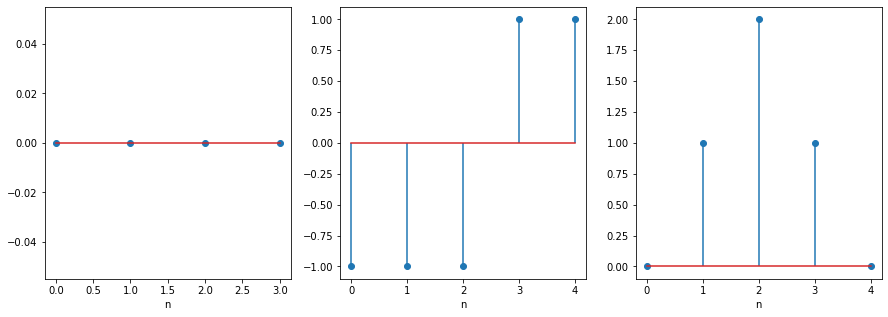

In [2]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.stem(np.zeros(4))
plt.xlabel("n")

plt.subplot(1, 3, 2)
plt.stem(np.array([-1, -1, -1, 1, 1]))
plt.xlabel("n")

plt.subplot(1, 3, 3)
plt.stem(np.array([0, 1, 2, 1, 0]))
plt.xlabel("n")

plt.show()

### Your Job

In the cell below:  
- Using the time indices $\{0, 1, ..., 19, 20\}$ (meaning we include the implicit zeros at $n=0,1,2,3,4,19,20$), define the piecewise constant signal $x$ as  

$$x(n) = \sum_{k = 5}^{9} \delta(n - k) + 3\sum_{k = 10}^{13} \delta(n - k) + 2\sum_{k = 14}^{18} \delta(n - k)$$  

- Define the edge detector's impulse response $h$, but only at its nonzero points (so that the numpy array representing $h$ contains two elements).
- Compute $y = x * h$ using np.convolve with "same" for the convolution mode.
- Finally, run the next cell to plot the results. 

In [3]:
def q1a():
    n = np.arange(21) # SOLUTION
    h = np.array([1, -1]) # SOLUTION
    x = np.concatenate([np.zeros(5), np.ones(5), 3 * np.ones(4), 2 * np.ones(5), np.zeros(2)]) # SOLUTION
    y = np.convolve(x, h, 'same') # SOLUTION
    
    return n, x, y

n, x, y = q1a()

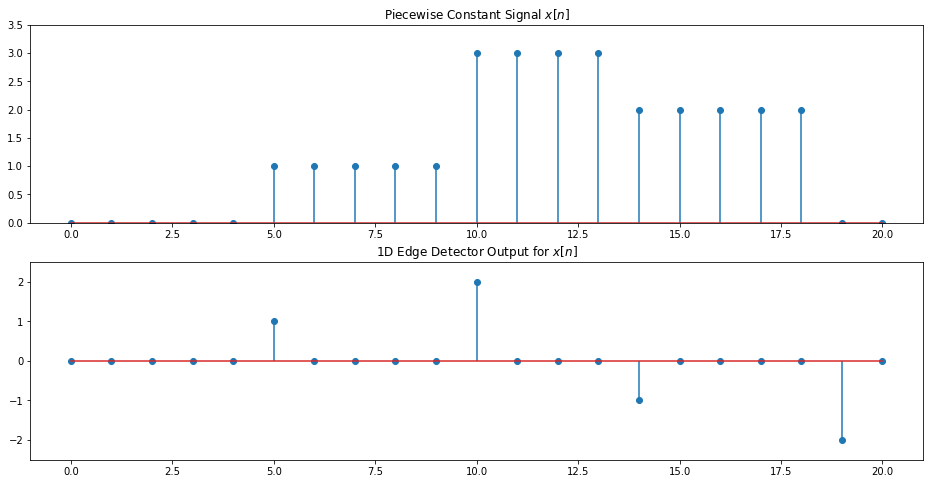

In [7]:
# Plot results
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.stem(n, x)
plt.ylim([0, 3.5])
plt.title("Piecewise Constant Signal $x[n]$")

plt.subplot(2, 1, 2)
plt.stem(n, y)
plt.ylim([-2.5, 2.5])
plt.title("1D Edge Detector Output for $x[n]$")

plt.show()

In [ ]:
grader.check("q1a-code")

<!-- BEGIN QUESTION -->

**Q:** $x$ is a piecewise-constant signal, changing a total of four times: once from $0 \rightarrow 1$, then $1 \rightarrow 3$, then $3 \rightarrow 2$, and finally $2 \rightarrow 0$. How many points of the edge detector's output are nonzero (that is, how many edges are detected)?

**Q:** One of the hottest areas of signal processing in the past ~15 years has been the study of sparse (mostly zero) signals, including both acquisition and representation, known as *compressed sensing*. A key part of compressed sensing algorithms is applying some *sparsifying transform* to signals that retain all the signal's information (i.e., the original signal could be completely recovered from the transformed one) but result in a new signal that is mostly zero. 

Suppose you're interested in developing compressed sensing algorithms for piecewise constant signals, and are in need of a way to sparsify them. How would you do so by only using the first signal value, $x(0)$, and using an LTI filter of your choice as the sparsifying transform? Explain both what LTI filter you would use, and how to recover the original signal from the filtered one. You can ignore noise that would be present for real world signals — assume the signal truly is piecewise-constant like the ones above. Also, you may assume $x(n) = 0$ for $n < 0$, since this is basically what we're doing in the digital setup.

_Type your answer here, replacing this text._

<span style="color:blue">**A:** Four times, one for each of these edges.</span>

<span style="color:blue">**A:**  Save the first signal value, $x(0)$, and apply an edge detector as the sparsifying transform. The new signal will be zero everywhere except at the transitions, and you can still completely recover the original by starting with $x(0)$ and outputting that until the transition, then just add that to $x(0)$ and keep outputting that, and so on until you hit the end. This idea, slightly modified to account for real world issues such as noise, is actually used by thresholding algorithms in compressed sensing for creating sparse representations of (approximately) piecewise constant signals!</span>

<!-- END QUESTION -->

<a id='q1b'></a>
## Q1b: The Edge Detector as a DT Differentiator

The 1D edge detector is sometimes also referred to as a *moving difference* filter, since it operates by subtracting adjacent points. This has a particularly nice connection to the idea from calculus of taking a derivative of a function, and many properties of the 1D edge detector can be discovered by considering it as a discrete-time analogue of taking a signal's derivative. 

Recall that given a function $f: \mathbb{R} \xrightarrow{} \mathbb{R}$, the derivative of $f$ is defined as

$$f'(t) = \lim_{\Delta t \xrightarrow{} 0}\dfrac{f(t + \Delta t) - f(t)}{\Delta t}$$

and as we make $\Delta t$ smaller and smaller, we get better and better approximations of $f'(t)$. But in DT, all arguments to our signals have to be integers, so $\Delta t$ has to be an integer. The smallest positive nonzero value it can take, then, is 1, in which case we recover the formula for the 1D edge detector.

Equipped with this knowledge, we'll revisit some of the results you saw in calculus, but using DT signals analogous to some of the real-valued functions you're familiar with.

### Your Job

In the cell below:
- Create a length 50 *ramp signal* $x$, defined as
$$x(n) = \sum_{k=1}^{50} k \delta(n - k) = \delta(n - 1) + 2 \delta(n - 2) + 3 \delta(n - 3) +\ ...\ + 50 \delta(n - 50)$$
- Compute $y = x * h$ in "valid" mode (we only care about points of full overlap), where $h$ is the same impulse response from Q1a.
- We have provided code to plut $x$ and $y$ in separate figures as stem plots.

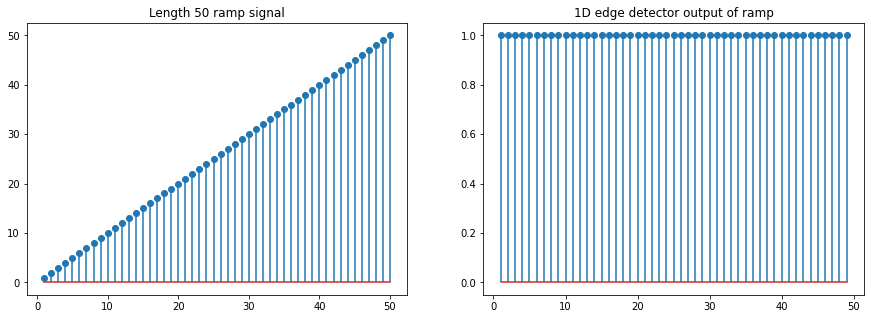

In [8]:
def q1b_ramp():
    x = np.arange(1, 51) # SOLUTION
    h = np.array([1, -1]) # SOLUTION
    y = np.convolve(x, h, "valid") # SOLUTION
    
    return x, y


x, y = q1b_ramp()

n_x = np.arange(1, 51) 
n_y = np.arange(1, 50) # y will have one less value, since the convolution method is "valid"

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Length 50 ramp signal")
plt.stem(n_x, x)

plt.subplot(1, 2, 2)
plt.title("1D edge detector output of ramp")
plt.stem(n_y, y)
plt.show()

In [ ]:
grader.check("q1b-ramp-code")

<!-- BEGIN QUESTION -->

**Q:** What continuous function $f(t)$ does the DT signal $x(n)$, the input to our filter, remind you of? What is its derivative $f'(t)$? Does the filter output $y(n)$ match?

_Type your answer here, replacing this text._

<span style="color:blue">**A:** The signal looks like $f(t) = t$, a linearly increasing signal with slope 1. $f'(t) = 1$, which matches our result exactly. This makes sense, as the input signal is essentially a truncated version of $x(n) = n$, and the filter output is $y(n) = x(n) - x(n-1) = n - (n-1) = 1$.</span>

<!-- END QUESTION -->

Let's do another! In the cell below:
- Create a length 50 quadratic signal $x(n) = n^2$ for $n = 1, ..., 50$.
- Compute $y = x * h$, again in "valid" mode. Remember, $h$ is the (unpadded, length 2) edge detector impulse response.
- We have plotted $x$ and $y$ the same as in the previous example, in separate figures with $x$ above $y$.

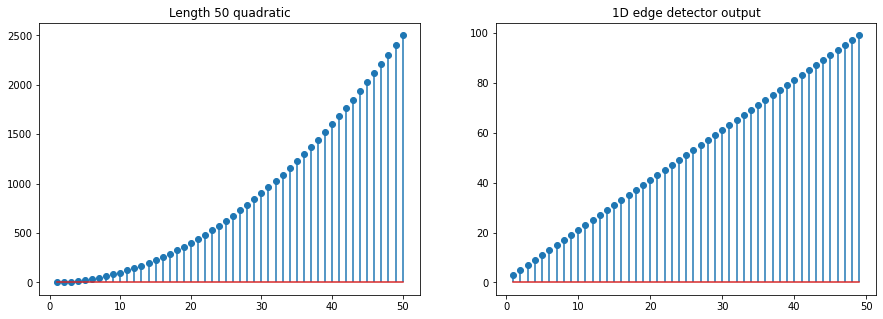

In [10]:
def q1b_quadratic():
    x = np.arange(1, 51) ** 2 # SOLUTION
    h = np.array([1, -1]) # SOLUTION
    y = np.convolve(x, h, "valid") # SOLUTION
    
    return x, y

x, y = q1b_quadratic()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Length 50 quadratic")
plt.stem(n_x, x)

plt.subplot(1, 2, 2)
plt.title("1D edge detector output")
plt.stem(n_y, y)

plt.show()

In [ ]:
grader.check("q1b-quadratic-code")

<!-- BEGIN QUESTION -->

**Q:** What continuous function $f(t)$ does the DT signal $x(n)$, the input to our filter, remind you of? What is its derivative $f'(t)$? Does the filter output $y(n)$ (roughly) match this shape? You can ignore any vertical offsets or rescaling differences.

_Type your answer here, replacing this text._

<span style="color:blue">**A:** The signal looks like $f(t) = t^2$, a quadratic function. $f'(t) = 2t$, which matches our output to within a vertical offset. Our output isn't *exactly* $y(n) = 2n$; instead it's $y(n) = 2n - 1$. This is an artifact of our "$\Delta t = 1$ approximation" of the derivative, rather than taking a true derivative. To see why, note that with $x(n) = n^2$, we have $y(n) = x(n) - x(n-1) = n^2 - (n-1)^2 = n^2 - (n^2 - 2n + 1) = 2n - 1$. The output signal actually appears to be a shifted up from this, but that's due to the fact that we've chopped off parts of the convolution output by using "valid" mode. You didn't have to note any of this; it's included for sake of completeness.</span>

<!-- END QUESTION -->

Let's do one more example, but with a sine wave instead of another polynomial. In the cell below:
- Create a 101-point sine wave $x$, defined for $n=0$ to $n=100$ inclusive, with a period of 50 points. This corresponds to an angular frequency of $\omega_0 = 2\pi / 50$, defined for you below, so that $x(n) = \sin(\omega_0 n)$ is the desired signal.
- Compute $y = x * h$, again in "valid" mode. Remember, $h$ is the (unpadded, length 2) edge detector impulse response.
- We have plotted $x$ and $y$ the same as in the previous example, in separate figures with $x$ above $y$.

This one is a bit more interesting to analyze.

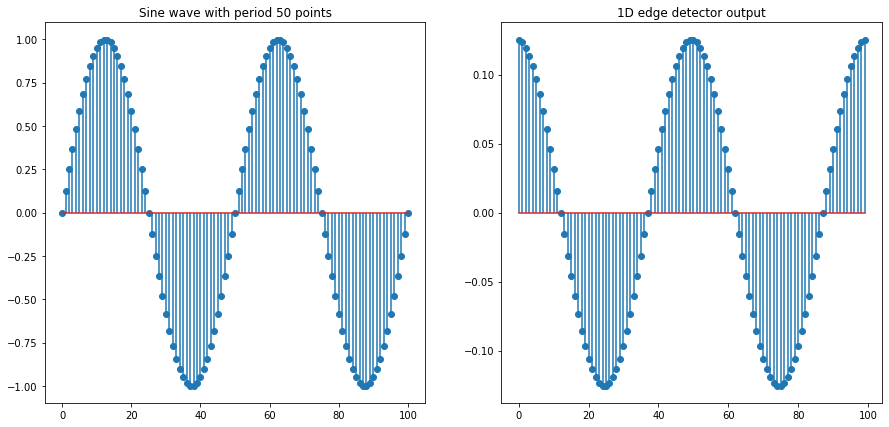

In [12]:
period = 50 # in points
omega_0 = 2 * np.pi / period

def q1a_sin():
    n = np.arange(0, 101) # SOLUTION
    x = np.sin(omega_0 * n) # SOLUTION
    h = np.array([1, -1]) # SOLUTION
    y = np.convolve(x, h, "valid") # SOLUTION
    
    return x, y

x, y = q1a_sin()

n_x = np.arange(0, 101) 
n_y = np.arange(0, 100) # y will have one less value, since the convolution method is "valid"

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Sine wave with period {} points".format(period))
plt.stem(n_x, x)

plt.subplot(1, 2, 2)
plt.title("1D edge detector output")
plt.stem(n_y, y)
plt.show()

In [ ]:
grader.check("q1b-sin-code")

<!-- BEGIN QUESTION -->

**Q:** What continuous function $f(t)$ does the DT signal $x(n)$, the input to our filter, remind you of? What is its derivative $f'(t)$? Does the filter output $y(n)$ match the *rough shape* of this derivative?

**Q:** An important property of LTI systems — including our 1D edge detector — is that they cannot create new frequencies. Our input can be decomposed as

$$\sin(\omega_0 n) = \dfrac{e^{i\omega_0 n} - e^{-i\omega_0 n}}{2i}$$

and thus only contains the frequencies $\pm \omega_0$. Visually, does it appear that our output contains any new frequencies, or not? Don't overthink this.

_Type your answer here, replacing this text._

<span style="color:blue">**A:** The signal looks like $f(t) = \sin(\omega_0 t)$, a sine wave at frequency $\omega_0$. Specifically,  $\omega_0 = 2\pi / 50$ here. $f'(t) = \omega_0 \cos(\omega_0 t)$, a cosine at frequency $\omega_0$ scaled by $\omega_0$. Do note the scaling as predicted by the chain rule for derivatives — the maximum value of the filter output is now $2\pi / 50 \approx .125$, not 1. Yes, the filter output matches this (roughly). It's important to stress, just as in the quadratic case, that there won't be an exact match since we're using a DT approximation to the derivative. The expression for the true output is a bit funkier, but numerically very close to what we obtained here (within ~.001 for all points).</span>

<span style="color:blue">**A:** It appears no new frequencies have been created, and that the output also has a period of 50 points. This is all you were required to say. Through some work, we can show that the output is actually $\sin(\omega_0 n)(1 - \cos(\omega_0)) + \cos(\omega_0 n) \sin(\omega_0)$, which confirms our suspicions.</span>

<!-- END QUESTION -->

<a id='q1c'></a>
## Q1c: "Differentiating" Noise

So far, we've explored two important features of the edge detector:
1. As the name suggests, it finds the input's edges — points where the signal value changes.
2. It acts like a differentiator, returning an approximate derivative of the input signal.

Now, we'll analyze its behavior when given a more chaotic input, namely *Gaussian noise*. 

### Gaussian Noise

In general, signal processing tasks involve some information-bearing signal $x$ that we want to somehow process. For example, $x$ may be human speech representing a voice command given to Siri, which goes through some speech recognition algorithm so Siri can interpret and carry out the command.

However, we rarely (if ever) have access to $x$ directly. Instead, we have to work with $\tilde{x} = x + z$, where $z$ is another signal — typically thought of as being random — referred to as *noise*. This noise corrupts the information-bearing signal $x$. This presents an extra layer of complexity in real-world signal processing tasks: will our algorithms still work as intended when operating on the noised signal $\tilde{x}$ instead of the clean signal $x$?

The answer depends on $z$, of course, so we need a reasonable model for how the noise behaves. Typically, we assume $z$ is *Gaussian noise*. Don't worry too much about what this means. The important takeaway is that we're generating a signal that will look like a series of values randomly jumping back and forth across some average value, typically taken to be zero.

### Your Job

The signal `noise` is defined for you below.

In [16]:
noise = np.random.normal(0, 5, 1000)

Now, add code to apply the (unpadded, i.e. the numpy array is length 2) edge detector to it, and store the result in `noise_filt`. Again, use "valid" as the convolution mode. Plotting code has been provided for you. You don't have to do much coding for this part.

Note that we'll start using `plt.plot` from here on out. We'll be using longer signals (we generated 1000 samples of noise) and in addition to `plt.plot` being more efficient, it'll be much easier to visualize our results, as mentioned in "Background".

<!-- BEGIN QUESTION -->



In [17]:
# Your filtering code here
noise_filt = np.convolve(noise, [1, -1], 'valid') # SOLUTION

The signals `noise_filt` and `noise` will not necessarily fit within the -25 to 25 y-limits we've set for the plot. Since it's random, it's possible we'll draw values that, either before or after filtering, will go outside these limits.

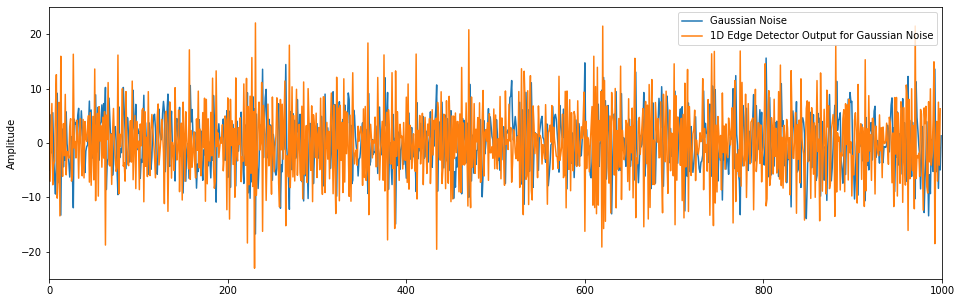

In [18]:
# Plot results
plt.figure(figsize=(16, 5))
plt.plot(noise)
plt.plot(noise_filt)
plt.ylim([-25, 25])
plt.ylabel("Amplitude")
plt.legend(("Gaussian Noise", "1D Edge Detector Output for Gaussian Noise"), loc="upper right")
plt.xlim([0,1000])
plt.show()

The plot should look kind of crazy. To help us understand what happened, we can turn to a salient summary statistic for random signals: *variance*.

You should see that both signals jump back and forth around zero. Each signal's variance will tell us, on average, how large these jumps are. Run the cell below to find the variance before and after applying the edge detector.

In [19]:
print("Noise variance before edge detector: {}".format(round(np.var(noise), 2)))
print("Noise variance after edge detector:  {}".format(round(np.var(noise_filt), 2)))

Noise variance before edge detector: 25.16
Noise variance after edge detector:  49.34


**Q:** What happens to the noise variance after we apply the edge detector? Does it increase or decrease, and by how much (e.g., does it double, triple, get cut in half, etc.)?

Based on this result, does the edge detector qualitatively amplify or suppress the "strength" of the noise? What implications might this have if we want to detect edges on a signal that has been corrupted by a large amount of noise?

_Type your answer here, replacing this text._

<span style="color:blue">**A:** The variance increases, roughly doubling. Thus the filter amplifies the noise. This is generally true of "differentiating filters", that is, they tend to amplify noise — the same is true of taking the derivative of a function. You'll see this idea when we discuss continuous-time LTI systems, and why it's better to implement CT-LTI systems described by linear constant-coefficient differential equations though integration than differentiation. The practical implication of this is that if we want to try and detect the edges of a signal that has been corrupted by noise, if the noise is too strong, we may end up misclassifying the noise as an edge. </span>

<!-- END QUESTION -->

<a id='q2'></a>
# Q2: Data Smoothing

One of the most common uses of LTI filters is in data smoothing. The applications are numerous, ranging from noise reduction, to extracting trends from complex data, to interpolation, and more. In this question, we'll explore the simplest, yet perhaps most widely used, data smoothing method in a few of these application spaces: a moving average filter.

<a id='q2a'></a>
## Q2a: Noise Reduction

The *simple* moving average filter is specified in terms of a single integer parameter, $L$, which represents the length of the filter. The filter takes the average of the $L$ points before, and including, the current point of a signal, outputting that average. Formally, the filter's impulse response is:

$$h_{SMA}(n) = \frac{\delta(n) + \delta(n - 1)\ +\ ...\ +\ \delta(n - (L - 1))}{L}$$

You probably recognize the impulse response, as it's just a length $L$ rect normalized to sum to 1. Note that the definition we'll use here is for the *causal* moving average filter: the output at any point in time is only computed as an average of the current and previous signal values. Causal systems can not "see the future" and are always at rest until a signal arrives (i.e their impulse response is 0 for $n<0$). This is, of course, very important in real-time systems since in real-time systems, we don't have access to the future.

The subscript "SMA" in the impulse response definition stands for *Simple Moving Average*, meaning all points are given equal weight in computing the average. This distinguishes the filter from more elaborate moving averages, such as the *Exponential Moving Average* (EMA) which gives more recent data points a higher weight. You'll get a chance to explore the EMA later in this Lab. We encourage you to check out reference [[1]](#references) for more on the theory behind the use of moving average filters for noise reduction if interested.

### Your Job: Signal Generation

In the cell below, do the following:
- Generate the time indices $\{0, 1, ..., 999, 1000\}$.
- Generate the signal $x[n] = e^{n / 300}$ over these time indices.
- Append 500 zeros onto the end of $x$, and extend your time indices to account for these extra data points. That is, your time indices should now be $\{0, 1, ..., 1000, 1001, ..., 1500\}$.
- Generate noise $z$ of the same dimensions as $x$, by using [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) with the parameters `loc=0, scale=4, size=np.shape(x)`. 
    - As a reminder, `np.shape(x)` returns how many entries `x` has along each dimension (here, our signal is 1D, so `np.shape` just returns the number of entries), which we can pass into a numpy function to easily generate numpy arrays (i.e. signals) of the same size as some other numpy array. 
- Create the noised signal $y = x + z$.
- On the same 16x4 figure, plot $x$ and $y$. Using [plt.legend](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.legend.html), label $x$ as "True Signal" and $y$ as "Noised Signal". **Make sure you use `plt.plot`, *not* `plt.stem`, for plotting.** You should use the time indices you generated as the first argument to `plt.plot`.

<!-- BEGIN QUESTION -->



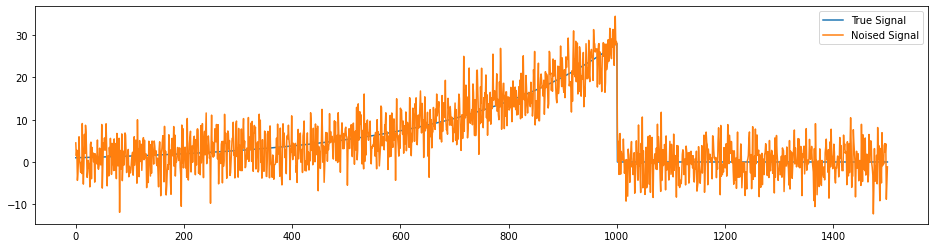

In [20]:
# BEGIN SOLUTION
n = np.arange(1001)
x = np.exp(n / 300)
n = np.concatenate((n, np.arange(1001, 1501)))
x = np.concatenate((x, np.zeros(500)))

z = np.random.normal(loc=0, scale=4, size=np.shape(x))
y = x + z
plt.figure(figsize=(16, 4))
plt.plot(n, x)
plt.plot(n, y)
plt.legend(("True Signal", "Noised Signal"))
plt.show()
# END SOLUTION

If your code is correct, you should see an exponential that rises in amplitude from 0 to ~30 over the course of the first 1000 samples followed by 500 zeros. Overlayed on top of it, you'll see a signal that jumps up and down, **but, on average, follows the sample amplitude as the original signal.**

### Your Job: Signal Denoising

Now that we've got a (not so) nice and noised up signal, let's try to denoise it with a moving average. Intuitively, since the noised signal follows, on average, the original one, we should be able to reduce the noise a bit by averaging adjacent data points. The hard part, and a great example of an engineering tradeoff, is figuring out the right number of points to average at a time. 

The array `filt_sizes` containing the different sizes (the parameter $L$ from above) we'll try out has been defined for you. In the cell below:
- Create a 20x35 figure. We will be creating a column of subplots, one for each filter length (note `len(filt_sizes)` is 7).
- For each filter size in `filt_sizes`,
    - Create a simple moving average filter, $h$, of that size.
        - Don't bother doing any zero padding of $h$. Instead, just construct the filter for all points where it is nonzero.
    - Compute $\hat{x} = y * h$, where $y$ is the noised growing exponential signal you created above. Naming this variable `x_hat` in your code is fine. **Use "full" as the convolution mode.** If we don't use "full", the filter will be non-causal due to the way we defined the impulse response. 
    - On a new subplot (that is, for each different moving average filter, we're using a separate subplot):
        - Plot $x$, the original (noiseless) signal. You can use the variable $n$ from above for the time indices.
        - Plot $\hat{x}$, the moving averaged version of $y$ you computed in the current loop iteration. 
            - Since we didn't use "same" for the convolution (motivated by the desire to have a causal filter), we need an expanded set of time indices to plot with. 
            - As a freebie, the code for this is `n_aug = np.concatenate((n, np.arange(n[-1], n[-1] + (len(x_hat) - len(n)))))`. This just adds on the extra indices to the end of the existing ones based on how much the convolution stretches the signal $x$ by.
        - Use `plt.legend` to label $x$ as "True Signal" and $\hat{x}$ as "Noised Signal after ?-point SMA", where "?" should be replaced by the current filter size. Python's [format](https://www.digitalocean.com/community/tutorials/how-to-use-string-formatters-in-python-3) function may be of use here.

**Note:** $\hat{x}$ and $h$ change with each new filter size; $x$ and $y$ do not.

**Hint 1:** It will be most informative to display our subplots as a column. Thus, your call to `plt.subplot` should look something like `plt.subplot(len(filt_sizes), 1, i)`  where `i` is a variable tracking which subplot we're currently on (i.e., it starts at 1, and should increase by 1 each time we create and apply a different moving average filter).

**Hint 2:** Make sure to call `plt.show()` *after* you've created all your subplots (i.e., it should NOT be called inside a loop). You only call `plt.show()` once per figure, i.e. after you're finished generating all the subplots.

In [22]:
filt_sizes = [2, 5, 10, 20, 50, 100, 500]

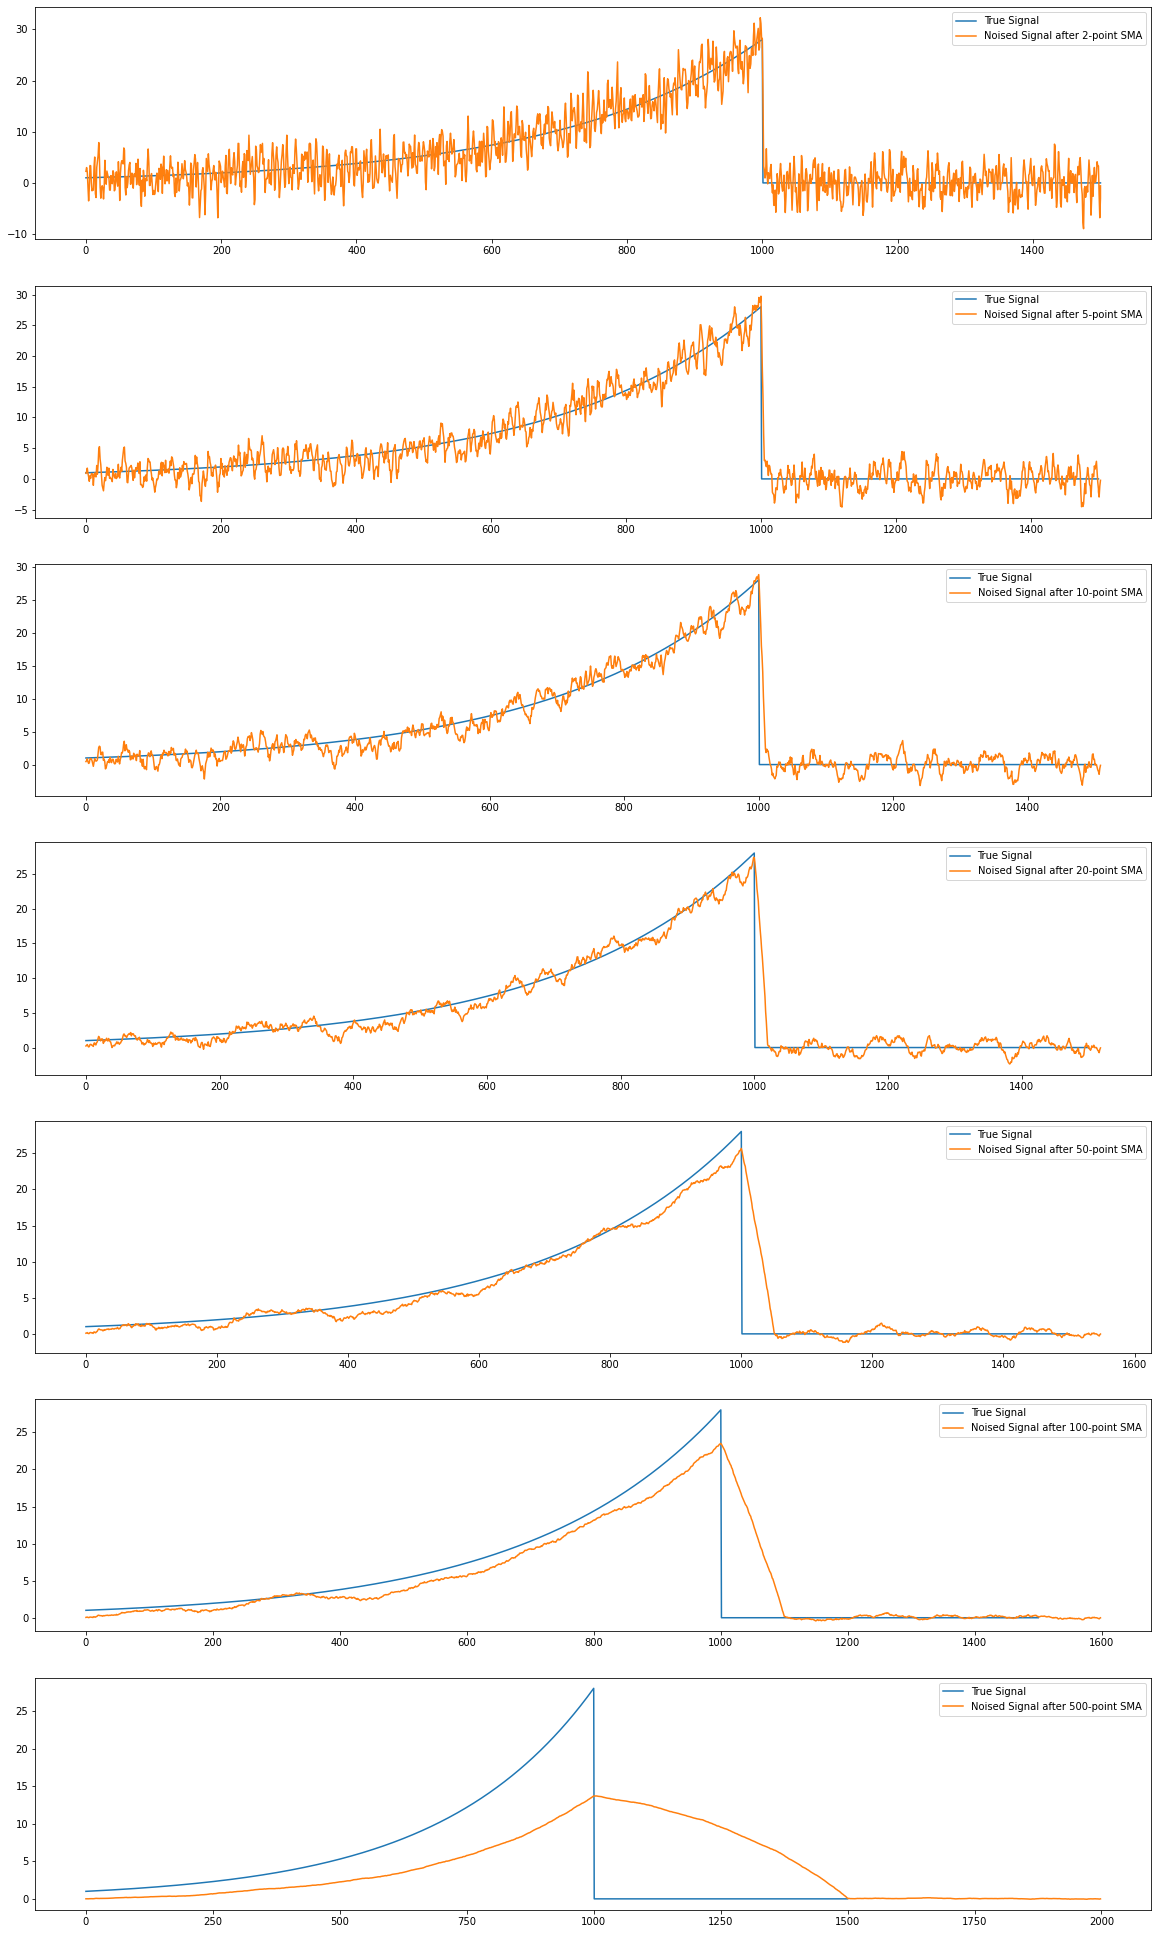

In [23]:
# BEGIN SOLUTION
plt.figure(figsize=(20, 35))
for i in range(len(filt_sizes)):
    plt.subplot(len(filt_sizes), 1, i+1)
    x_hat = np.convolve(y, np.ones(filt_sizes[i]) / filt_sizes[i], "full")
    n_aug = np.concatenate((n, np.arange(n[-1], n[-1] + (len(x_hat) - len(n)))))
    plt.plot(n, x)
    plt.plot(n_aug, x_hat)
    plt.legend(("True Signal", "Noised Signal after {}-point SMA".format(filt_sizes[i])))
plt.show()
# END SOLUTION

A few sanity checks:
- In all cases, the true signal should go from 0 to 1500 and look the same.
- As we increase the filter length, the noised signal (post-filtering) will be stretched further and further out, occupying just over 1500 points for the length 2 and length 5 filters, and about 2000 points for the length 500 filter.
- The peak of the noised signal (post-filtering) should always line up with the true signal's peak. This is a good sanity check that the filter is causal: if it doesn't look ahead, then the filter's first encounter with the peak will be averaging the peak with the previous (positive) values, resulting in a peak in the output. After the filter sees the true signal's peak, it only sees zeros, so averaging in more and more zeros instead of the positive values on the exponential will lead to smaller and smaller output values.

### Analyzing the plots

Answer the following questions:

1. **Q:** As we increase the filter length, do the first 400-500 points of the filtered signal get smoothed out (reducing the noise at these points) or blown up (amplifying the noise)? Ignore any scaling differences; that is, if the filtered signal looks the same as the true one except for being off by a constant scaling factor, that's fine.

2. **Q:** As we increase the filter length, what happens to our signal's sharp, high-frequency feature, the drop off from the top of the exponential back down to zero (at $n=1000$)? Is this high-frequency feature preserved, or does it get more and more distorted? Explain, based on the moving average filter, why this makes sense.

3. **Q:** Putting your previous answers together, what advantage is there to using a longer moving average for noise reduction? What do we have to trade off (i.e., what disadvantage becomes more and more pronounced) in doing so?

4. **Q:** Assuming you equally prioritize minimizing distortion of sharp, high-frequency features while still getting a reasonable amount of noise reduction, which of the following moving average filter lengths would you pick from above for denoising this specific signal? There are multiple correct answers; just be sure to justify your choice.

_Type your answer here, replacing this text._

<span style="color:blue">**A:**
    
1. They're smoothed out, and we recover successively better approximations of the true signal in this region. Since our noise is zero-mean, as we average more and more points, the noise will cancel out and we'll improve the strength of our signal.
    
2. As we see, it's distorted further and further as we increase the filter length. As we increase the filter's length, we perform more and more averaging, so the points corresponding to this sharp transition are computed as averages of more and more points that aren't near it. Since the signal changes so rapidly in this regime, the points that aren't near it have amplitudes that differ by a lot, thus creating the distortion.
 
3. Using a longer moving average will indeed reduce the signal's noise more and more, but at the cost of distorting its high-frequency features. This is the fundamental engineering tradeoff in picking the length of a moving average filter: how much high-frequency distortion are you willing to accept as the price of reducing your signal's noise content? The answer to that question depends on the context, and even the signal itself.
    
4. 10 looks appealing as there's little to no visible distortion of our high-frequency jump and we get a decent amount of noise reduction. 20 and 50 are also a reasonable choices, as they provide some, but not too much, HF (high frequency) distortion, while reducing our noise even further.

</span>

<!-- END QUESTION -->

<a id='q2b'></a>
## Q2b: Extracting Trends from Data

In addition to its use in signal processing and statistics for noise reduction, the moving average filter is popular in analysis of financial data for highlighting trends in stock prices.

Here, we'll analyze one of the most common datasets in time series analysis: stock price data! Run the cell below to load it. We will be taking a look at Apple's stock data from mid 2017 to early 2019.

We got this data from Yahoo! finance. If you are interested in playing around with stock data on your own, you can click on a stock, navigate to the historical data tab, download a csv file, and use our code below to parse it. Acquiring data often plays second fiddle to all the fancy algorithms used on it despite being just as important a part of any engineering field that relies on it. However, here, we want to focus on the algorithms, not the minutiae of Yahoo! csv file formats, hence why we provide the code to read the data in.

In [26]:
stock_dates, stock_prices = lab2_helper.load_stock_prices()

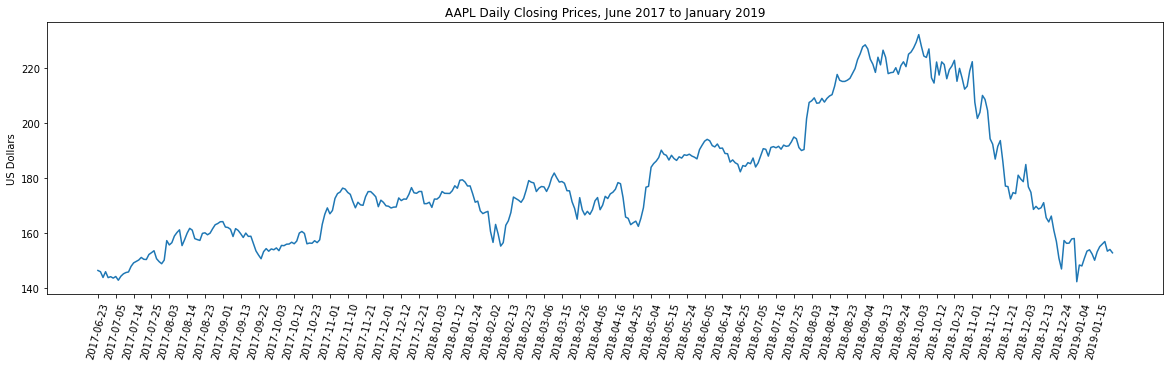

In [27]:
# 400 most recent days
start = -400
end = -1
x = np.arange(len(stock_prices[start:end]))

# Plot roughly one data point per week (x[::7]) so we can display dates 
# without matplotlib going crazy about the labels overlapping
plt.figure(figsize=(20, 5))
plt.xticks(x[::7], stock_dates[start:end:7], fontsize=10, rotation=75)
plt.plot(x, stock_prices[start:end])
plt.title("AAPL Daily Closing Prices, June 2017 to January 2019")
plt.ylabel("US Dollars")
plt.show()

### Your Task

Your job is to fill in the missing parts of the cell below to filter the noise with moving average filters of length 5, 25, and 75, and be sure to answer the question about interpreting the results below the cell. Unlike Q2a, most of the work has been done for you here.

In the cell below:
- Define the moving average impulse responses as `MA5, MA25, MA75` respectively.
    - Again, don't bother with any zero padding - just define them at their nonzero points.
- Filter your test data (`data`) with each of them using **convolution with the "same" mode**. We'll call the outputs `y5, y25`, and `y75`, respectively.

*Note:* **Here, we are *not* using causal moving averages as we did in Q2a.** The motivation in doing so is that we want the filtered signals to temporally align with the original to make the results easier to interpret. While real-time filters have to be causal, we're working in an offline setting with pre-collected data here, so causality is less important, and interpretability is more useful. These properties are some of the tradeoffs involved in how data processing is done.

Plotting code has been provided for you. To generate the results, simply run the cell after adding your own code.

In [28]:
data = stock_prices[start:end]

In [29]:
## Your impulse response definitions here
MA5 = np.ones(5) / 5 # SOLUTION
MA25 = np.ones(25) / 25 # SOLUTION
MA75 = np.ones(75) / 75 # SOLUTION

In [30]:
## Your filtering code here
y5 = np.convolve(data, MA5, 'same') # SOLUTION
y25 = np.convolve(data, MA25, 'same') # SOLUTION
y75 = np.convolve(data, MA75, 'same') # SOLUTION

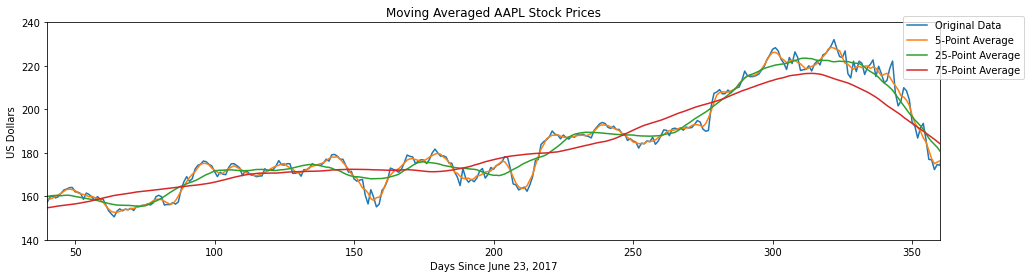

In [34]:
# Overlay stock prices
plt.figure(figsize=(16, 4))
plt.plot(np.arange(len(data)), data)
plt.plot(np.arange(len(data)), y5)
plt.plot(np.arange(len(data)), y25)
plt.plot(np.arange(len(data)), y75)

# Formatting mumbo jumbo to abstract away boundary issues
plt.xlim([40, 360])
plt.ylim([140, 240])
plt.legend(('Original Data', '5-Point Average', '25-Point Average', '75-Point Average'), bbox_to_anchor=(1.1, 1.05))
plt.ylabel("US Dollars")
plt.xlabel("Days Since June 23, 2017")
plt.title("Moving Averaged AAPL Stock Prices")
plt.show()

In [ ]:
grader.check("q2b-code")

<!-- BEGIN QUESTION -->

**Answer the following questions**

1. **Q:** As we use longer and longer moving average filters to process our signal (the stock data), does the filtered signal highlight longer term trends, or shorter term trends? Explain in 1-2 sentences.

2. **Q:** Suppose that you had the closing price of Microsoft stock (MSFT) for every day it's existed, 1986 to present (~8000-10000 data points, one per day), and wanted to see how the company's stock price changed at the level of trends that occur over the course of a year using a moving average filter. How long of a moving average would you use? Why?

_Type your answer here, replacing this text._

<span style="color:blue"> **A:**

1. Longer term. As we use longer and longer filters, our filtered signal values correspond to taking longer and longer averages, so short-term fluctuations are eliminated, with more "big picture" trends emerging. This can be seen in the 75-point average, where we see the filtered trend resembing a line, acting like a first-order approximation to the data. 
    
2. The stock market is open ~253 days a year, so a length 250-255 filter would be the most appropriate choice. Many students answered 365; no points were deducted for this. Such a filter would pick out 16-18 month trends, which would be an approximation of annual trends. Additionally, we don't expect you to know how many days a year the stock market is open, although a quick Google search will tell you the answer.

</span>

<!-- END QUESTION -->

<a id='q3'></a>
# Q3: The MACD Indicator

The Moving Average Convergence Divergence (MACD) Indicator is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price. In this question, we'll use the MACD indicator as a vehicle for introducing the exponential moving average as well as some more uses of signal processing in financial analysis.

<a id='q3a'></a>
## Q3a: The Exponential Moving Average

To calculate the MACD of a stock, we first have to understand a new kind of moving average, called the *Exponential Moving Average* (EMA). What we did earlier is known as an Simple Moving Average (SMA) - all points are given equal weight. An EMA, on the other hand, places a greater weight, and therefore significance, on the most recent data points. The benefit of the EMA over the SMA is that the EMA reacts faster to recent price changes. 

### Derivation

Let's take a look at where the EMA comes from. We can express the EMA using the following recursive Linear Constant Coefficient Difference Equation (LCCDE): 

$$y(n)=\alpha\cdot x(n) + (1-\alpha)\cdot y(n-1)$$

where $y(n)$ is the filter output at day $n$, and $x(n)$ is the stock price at day $n$. The output, $y(n)$, is a linear combination of the previous output of the filter, $y(n-1)$, and the current signal value, $x(n)$.

Now, why is this an "exponential" moving average? It might not be obvious when written it in this form. Let's write it out step by step to try to unravel the recursion. We'll assume a causal filter, and that the input signal $x$ is zero for all $n < 0$, so that $n=0$ represents the first point of stock data we have, with others filled in as zero.

Since we have a causal filter and $x(n) = 0$ for all $n<0$, we know that $y(n) = 0$ for all $n<0$, and:

$\begin{aligned}
    y(0) &= \alpha\cdot x(0) + (1-\alpha)\cdot y(-1) = \alpha\cdot x(0) \\
    y(1) &= \alpha\cdot x(1) + (1-\alpha)\cdot y(0) = \alpha\cdot x(1) + (1-\alpha)\cdot \alpha\cdot x(0) \\
    y(2) &= \alpha\cdot x(2) + (1-\alpha)\cdot y(1) = \alpha\cdot x(2) + (1-\alpha)\cdot (\alpha\cdot x(1) + (1-\alpha)\cdot \alpha\cdot x(0)) = \alpha\cdot x(2) + (1-\alpha)\cdot \alpha\cdot x(1) + (1-\alpha)^2\cdot \alpha\cdot x(0) \\
    &\vdots \\
    y(n) &= \alpha\sum_{k=0}^{n}(1-\alpha)^k\cdot x(n-k)
\end{aligned}$

Aha! Now that we have rewritten it, it's clear why we call this an EMA: we are weighting each previous data point with a value that decreases exponentially as we go further and further back in time.

### An LTI Perspective: The Impulse Response of an EMA Filter

We can input a Kronecker delta to the EMA system by setting $x(n) = \delta(n)$ to find its impulse response:

$$h(n)=\alpha\sum_{k=0}^{n}(1-\alpha)^k\cdot \delta(n-k)= \alpha (1-\alpha)^n u(n)$$

which is just what we would expect: a (one-sided) decaying exponential!

## Your Job

Fill in the `ema_filter` function below to create and return the impulse response of an EMA filter truncated after `length` points. The value of $\alpha$ has been determined for you already. **Make sure you normalize the impulse response to sum to 1.**

*Hint:* When we truncate the impulse response, the signal doesn't sum to 1 anymore. What can we scale the signal by so that it sums to 1?

In [35]:
def ema_filter(length):
    alpha = 2/(length+1)
    # Create and return an EMA filter with length "length"
    # BEGIN SOLUTION
    n = np.arange(length)
    h = [alpha*(1-alpha)**i for i in n]
    h = h/sum(h)
    return h
    # END SOLUTION

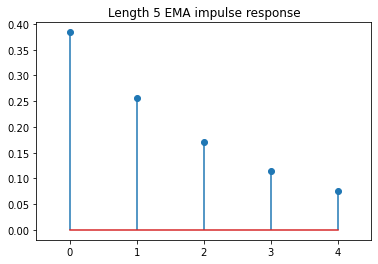

In [39]:
# Run me to plot!
h = ema_filter(5)
plt.figure()
plt.title("Length 5 EMA impulse response")
plt.xlim([-.5, 4.5])
plt.stem(h)
plt.show()

We can now convolve data with the impulse response to calculate the EMA! Note that if we flipped this signal (as we'd do in convolving) and slid it across some data signal, pointwise multiplying and summing to calculate our EMA, the strongest point would always be at the front, with an exponential drop-off as we go further and further back along the impulse response.

**2 Quick Things to Note:**

1. The LCCDE we originally gave describes an IIR filter, but we are using an FIR filter - after all, we can't store infinitely many values on a computer. In order to account for this, we truncate as is typically done, but we also renormalize so that the sum of the impulse response's coefficients, known as the DC gain, is 1.

2. The value for $\alpha$ that we have picked is motivated by reducing the output noise variance. We have a provided a reference below if you wish to read more about this.

In [ ]:
grader.check("q3a")

<a id='q3b'></a>
## Q3b: The MACD Line

The *MACD line* is calculated by taking the difference between the 26-day EMA of the stock and its 12-day EMA. In the cell below, we've defined an array of values, `data`, for you based on the same AAPL stock data we used earlier in this lab. In the cell below, calculate the MACD line. To do so,
- Create a length 26 EMA filter, $h_{26}$.
- Create a length 12 EMA filter, $h_{12}$.
- Calculate the 26-day EMA as $y_{26} = x * h_{26}$, where $x$ is `data`. **Use "valid" as the convolution mode** - we only want points where our signals fully overlap.
- Calculate the 12-day EMA as $y_{12} = x * h_{12}$. Again, use "valid" as the convolution mode.
- Crop $y_{12}$ by discarding its first 14 values, so that $y_{26}$ and $y_{12}$ have the same length. 
    - The first value in $y_{26}$ is an EMA taken over data points 1 through 26 (since the first point the signals fully overlap is at day 26), representing the exponential average at day 26, factoring in the previous 25 days. By cropping out the first 14 values of $y_{12}$, we ensure the first point in its output also corresponds to an EMA for day 26, but taken over the most recent 12 days rather than 26, essentially "aligning" the outputs.
- Compute the MACD line as $y_{12} - y_{26}$. **Store your result in a variable called `MACD`, as our plotting code uses this.**

In [41]:
# Stock data
data = stock_prices[start:end]

# Calculate macd line
h26 = ema_filter(26) # SOLUTION
h12 = ema_filter(12) # SOLUTION
EMA26 = np.convolve(data, h26, "valid") # SOLUTION
EMA12 = np.convolve(data, h12, "valid")[14:] # SOLUTION
MACD = EMA12 - EMA26 # SOLUTION

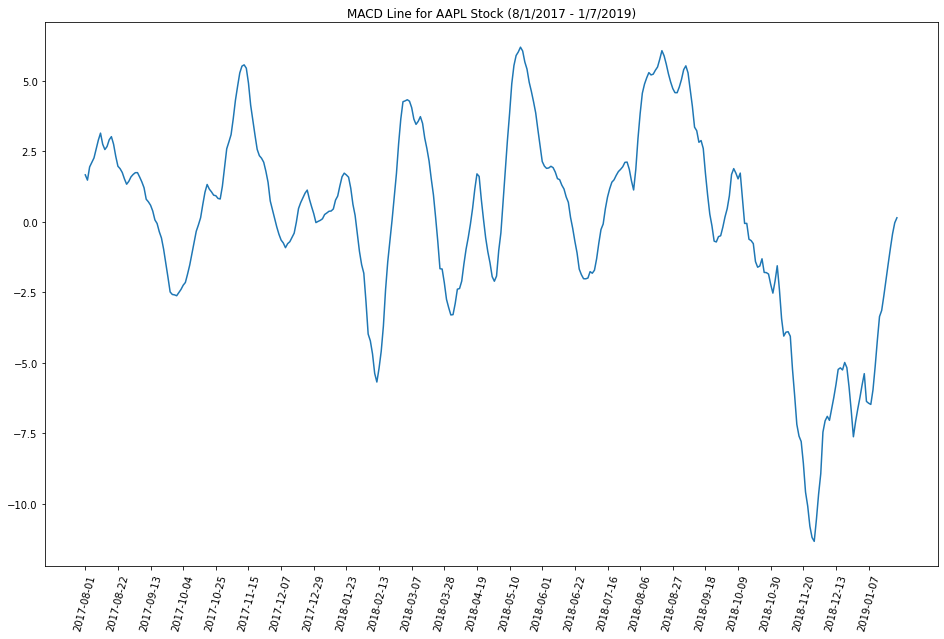

In [47]:
# Plotting Code
x = np.arange(len(MACD))
fig = plt.figure(figsize=(16, 10))
plt.xticks(x[::15], stock_dates[start+26:end:15], fontsize=10, rotation=75)
plt.plot(MACD)
plt.title("MACD Line for AAPL Stock (8/1/2017 - 1/7/2019)")
plt.show()

In [ ]:
grader.check("q3b")

<a id='q3c'></a>
## Q3c: The Signal Line

Now that we have the MACD line, we want to take the 9-day EMA of the MACD line to create the *signal line*. Once equipped with the MACD line and the signal line, we can analyze the stock data. 

Add code in the top of the cell below to calculate the signal line by applying a 9-day EMA filter (use "same" as the convolution mode this time) to your MACD line, `MACD`, from above. Plotting code has been provided for you.

TODO:
* Create a length 9 EMA filter, $h_{9}$
* Calculate the 9-day EMA on the MACD signal you found earlier

In [48]:
# Your signal line calculation here
h9 = ema_filter(9) # SOLUTION
EMA9 = np.convolve(MACD, h9, mode='same') # SOLUTION

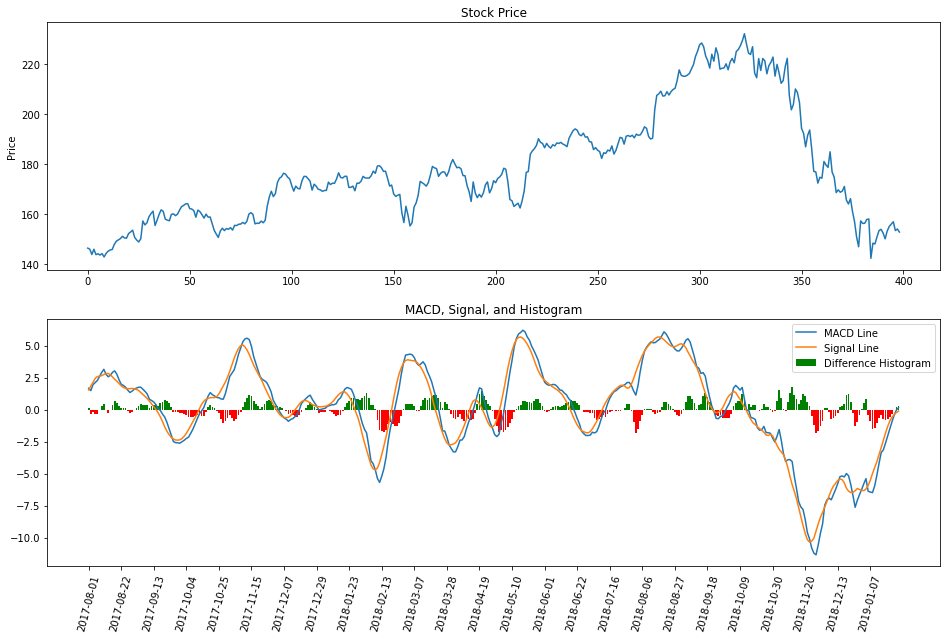

In [53]:
# Plotting Code
c = ['green', 'red']
colors = [c[bool(i)] for i in np.greater(EMA9, MACD)]
x = np.arange(len(EMA9))

plt.figure(figsize=(16,10))

plt.subplot(2,1,1)
plt.title("Stock Price")
plt.plot(data)
plt.ylabel("Price")

plt.subplot(2,1,2)
plt.title("MACD, Signal, and Histogram")
plt.xticks(x[::15], stock_dates[start+26:end:15], fontsize=10, rotation=75)
plt.plot(MACD, label='MACD Line')
plt.plot(EMA9, label='Signal Line')
plt.bar(range(len(EMA9)),(MACD-EMA9), color=colors, label="Difference Histogram")
plt.legend()
plt.show()

If done correctly, you should see that the signal line resembles a smoothed, shifted (slightly to the left) version of the MACD line, and the difference histogram is green where the MACD Line is above the signal line, and red where the signal line is above the MACD line.

## (OPTIONAL) Interpretation of the MACD Indicator (from *Technical Analysis* [[3]](#references))

In signal processing terms, the MACD is a filtered measure of velocity. The velocity has been passed through two first-order linear low-pass filters (the EMA filters). The signal line is that resulting velocity, filtered again. The difference between those two, the histogram, is a measure of the acceleration, with all three filters applied. A MACD crossover of the signal line indicates that the direction of the acceleration is changing. The MACD line crossing zero suggests that the average velocity is changing direction.

**Q:** Using this analogy of velocity and acceleration, we can think of a stock's price as a the position of the car. We know its velocity and acceleration from the MACD and histogram, respectively. What do points where the difference histogram is positive tell us about how the stock is behaving, and how can we use this information to decide whether or not to invest in a stock? How about when the difference histogram is negative?


_Type your answer here, replacing this text._

<span style="color:blue">**A:**  There are several correct answers for this question. Note that near 2-13-2018, the velocity is positive but the acceleration is negative. Using the car analogy, the stock is "moving forward" but "slowing down," and we see that soon after that the stock changes direction. Many such points can be seen in the plots, and these give us indicators of how the stock might move going forward, and aid us in making decisions on how to invest. Exactly how is not really in the scope of this class, you can learn more about it by reading reference [3].</span>

In [ ]:
grader.check("q3c-code")

<a id='references'></a>
# References
[1] *The Scientist and Engineer's Guide to Digital Signal Processing. Chapter 15, Moving Average Filters.* [Link](https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch15.pdf)  
[2] *Moving Average Convergence Divergence - Investopedia.* [Link](https://www.investopedia.com/terms/m/macd.asp)  
[3] *Technical Analysis*. [Link](http://www.mrao.cam.ac.uk/~mph/Technical_Analysis.pdf)  
[4] *Systems and Control Theory - Exponential Moving Average.* [Link](https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/Digital-filters/Exponential%20Moving%20Average/Exponential-Moving-Average.html) 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Please upload the zip file produced by the result of this command to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)